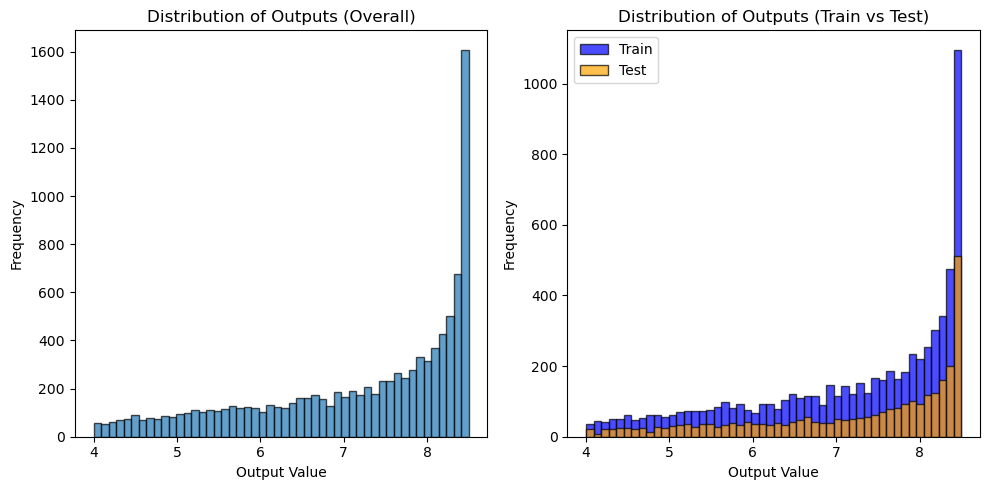

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn, optim
from dataset import MyDataset
from torch.utils.data import DataLoader
from utils import *
import seaborn as sns
from net1d import Net1D
from Dist_loss import DistLoss
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split

def generate_data(num_samples=10000, input_length=100):
    # Initialize arrays to store input and output data
    inputs = np.random.randn(num_samples, input_length)  # Random normal inputs
    outputs = []

    # Define the relationship between input and output
    def relationship_function(x):
        return np.sum(x) / input_length + 0.3 * np.sin(np.sum(x) / input_length) + 0.1 * np.random.randn()  # Add some noise

    for i in range(num_samples):
        input_sample = inputs[i]
        output_sample = relationship_function(input_sample)
        outputs.append(output_sample)

    # Convert outputs to numpy array
    outputs = np.array(outputs)

    # Apply a transformation to make the output distribution uneven (Gaussian-like distribution)
    mean = np.mean(outputs)
    std_dev = np.std(outputs)
    outputs = np.exp(-(outputs - mean) ** 2 / (2 * std_dev ** 2))

    # Normalize the outputs to be in the range of [4, 8.5] to simulate ages
    outputs = 4 + 4.5 * (outputs - outputs.min()) / (outputs.max() - outputs.min())

    return inputs, outputs

# Generate data
inputs, outputs = generate_data()

# Split data into training and testing sets (7:3 ratio)
train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size=0.3, random_state=42)

# Plot the distribution of outputs to verify it's uneven
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(outputs, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Output Value')
plt.ylabel('Frequency')
plt.title('Distribution of Outputs (Overall)')

plt.subplot(1, 2, 2)
plt.hist(train_outputs, bins=50, edgecolor='k', alpha=0.7, color='blue', label='Train')
plt.hist(test_outputs, bins=50, edgecolor='k', alpha=0.7, color='orange', label='Test')
plt.xlabel('Output Value')
plt.ylabel('Frequency')
plt.title('Distribution of Outputs (Train vs Test)')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
train_inputs = normalization(train_inputs)
train_inputs = np.expand_dims(train_inputs, axis=1)

test_inputs = normalization(test_inputs)
test_inputs = np.expand_dims(test_inputs, axis=1)

In [3]:
# label distribution estimation
bw_method = 0.2
min_label, max_label = 3, 10
step = 0.1

# dataloader
batch_size = 2048
shuffle = True
num_workers = 16
drop_last = True

density = get_label_distribution(train_outputs, bw_method, min_label, max_label, step)
batch_theoretical_labels = get_batch_theoretical_labels(density, batch_size, min_label, step=step)

In [5]:
train_ds = MyDataset(train_inputs, train_outputs)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, drop_last=drop_last)

test_ds = MyDataset(test_inputs, test_outputs)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

print(f"Training data size: {len(train_ds)}")
print(f"Test data size: {len(test_ds)}")

Training data size: 7000
Test data size: 3000


In [6]:
# model
in_channels = 1
base_filters = 32
ratio = 1
filter_list = [64, 128]
m_blocks_list = [2, 2]
kernel_size = 5
stride = 2
groups_width = 32
verbose = False 
n_classes = 1

net = Net1D(
    in_channels=in_channels,
    base_filters=base_filters,
    ratio=ratio,
    filter_list=filter_list,
    m_blocks_list=m_blocks_list,
    kernel_size=kernel_size,
    stride=stride,
    groups_width=groups_width,
    verbose=verbose,
    n_classes=n_classes
    )
net = net.cuda()

In [7]:
# hyperparams
lr = 1e-2
weight_decay = 1e-4
epochs = 50
regularization_strength = 0.1
loss_weight = 1.0

dist_loss = DistLoss(loss_fn='L1', loss_weight=loss_weight)

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=epochs)

In [8]:
min_loss = float('inf')
batch_theoretical_labels = torch.tensor(batch_theoretical_labels, dtype=torch.float32).reshape(-1,1).cuda()

for epoch in range(epochs):
    loss = 0
    net.train()
    for batch_idx, (inp, tar) in enumerate(train_dl):
        inp, tar = inp.cuda(), tar.cuda()
        out = net(inp)
        total_loss = dist_loss(out, tar, batch_theoretical_labels)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        loss += total_loss
    loss = loss / (batch_idx + 1)
    if loss <= min_loss:
        best_loss = loss
        params = net.state_dict()
    scheduler.step()
    print(f"Epoch [{epoch+1:02d}/{epochs}], train loss: {loss.item():.3f} || lr: {optimizer.param_groups[0]['lr']:.5f}")

print("Training finished.")

Epoch [01/50], train loss: 9.202 || lr: 0.00999
Epoch [02/50], train loss: 8.138 || lr: 0.00996
Epoch [03/50], train loss: 4.554 || lr: 0.00991
Epoch [04/50], train loss: 3.094 || lr: 0.00984
Epoch [05/50], train loss: 2.260 || lr: 0.00976
Epoch [06/50], train loss: 2.235 || lr: 0.00965
Epoch [07/50], train loss: 2.218 || lr: 0.00952
Epoch [08/50], train loss: 2.093 || lr: 0.00938
Epoch [09/50], train loss: 1.869 || lr: 0.00922
Epoch [10/50], train loss: 1.835 || lr: 0.00905
Epoch [11/50], train loss: 1.815 || lr: 0.00885
Epoch [12/50], train loss: 1.765 || lr: 0.00864
Epoch [13/50], train loss: 1.799 || lr: 0.00842
Epoch [14/50], train loss: 1.686 || lr: 0.00819
Epoch [15/50], train loss: 1.684 || lr: 0.00794
Epoch [16/50], train loss: 1.614 || lr: 0.00768
Epoch [17/50], train loss: 1.605 || lr: 0.00741
Epoch [18/50], train loss: 1.576 || lr: 0.00713
Epoch [19/50], train loss: 1.554 || lr: 0.00684
Epoch [20/50], train loss: 1.533 || lr: 0.00655
Epoch [21/50], train loss: 1.500 || lr: 

In [9]:
pred, true = [], []

net.load_state_dict(params)

for inp, tar in test_dl:
    with torch.inference_mode():
        inp, tar = inp.cuda(), tar.cuda()
        out = net(inp)
        out = list(out.detach().cpu().numpy().squeeze())
        pred += out
        true += list(tar.cpu().numpy().squeeze())
pred = np.round(np.array(pred), 1)
true = np.round(np.array(true), 1)

error mean: -0.002, error std: 1.753


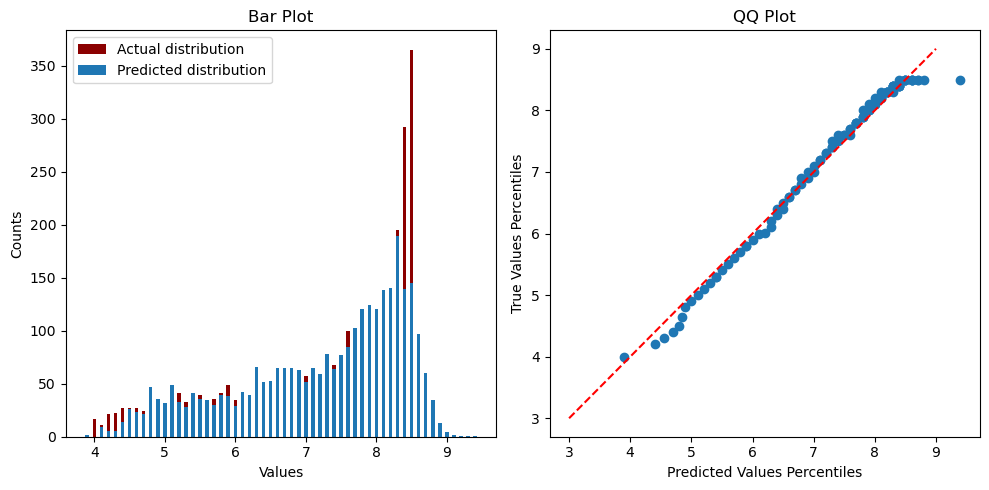

In [10]:
error = pred - true
mean = error.mean()
std = error.std()
print(f'error mean: {mean:.3f}, error std: {std:.3f}')
coef = np.corrcoef(pred, true)[0][1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

count_pred = Counter(pred)
count_true = Counter(true)
sorted_pred_keys, sorted_pred_values = zip(*sorted(zip(count_pred.keys(), count_pred.values())))
sorted_true_keys, sorted_true_values = zip(*sorted(zip(count_true.keys(), count_true.values())))
axs[0].bar(sorted_true_keys, sorted_true_values, alpha=1, width=0.05, color='darkred', label='Actual distribution')
axs[0].bar(sorted_pred_keys, sorted_pred_values, alpha=1, width=0.05, label='Predicted distribution')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Counts')
axs[0].set_title('Bar Plot')
axs[0].legend()

pred_percentiles = np.percentile(pred, np.linspace(0, 100, 100))
true_percentiles = np.percentile(true, np.linspace(0, 100, 100))
axs[1].plot(pred_percentiles, true_percentiles, marker='o', linestyle='')
axs[1].plot([3, 9], [3, 9], color='red', linestyle='--')  
axs[1].set_xlabel('Predicted Values Percentiles')
axs[1].set_ylabel('True Values Percentiles')
axs[1].set_title('QQ Plot')

plt.tight_layout()

plt.show()